##### Marc Vega Velilla, 1571616

Original dataset shape: Counter({0: 13631, 1: 526})
Resampled dataset shape: Counter({0: 13631, 1: 1363})

Training RandomForest...
Optimal threshold: 0.610

Training GradientBoosting...
Optimal threshold: 0.410

Training SVM...
Optimal threshold: 0.500

Training LogisticRegression...
Optimal threshold: 0.690

RandomForest Results:

Confusion Matrix:
[[3374   35]
 [  36   95]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3409
           1       0.73      0.73      0.73       131

    accuracy                           0.98      3540
   macro avg       0.86      0.86      0.86      3540
weighted avg       0.98      0.98      0.98      3540

ROC AUC Score: 0.9847

GradientBoosting Results:

Confusion Matrix:
[[3370   39]
 [  31  100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3409
           1       0.72      0.76      0.

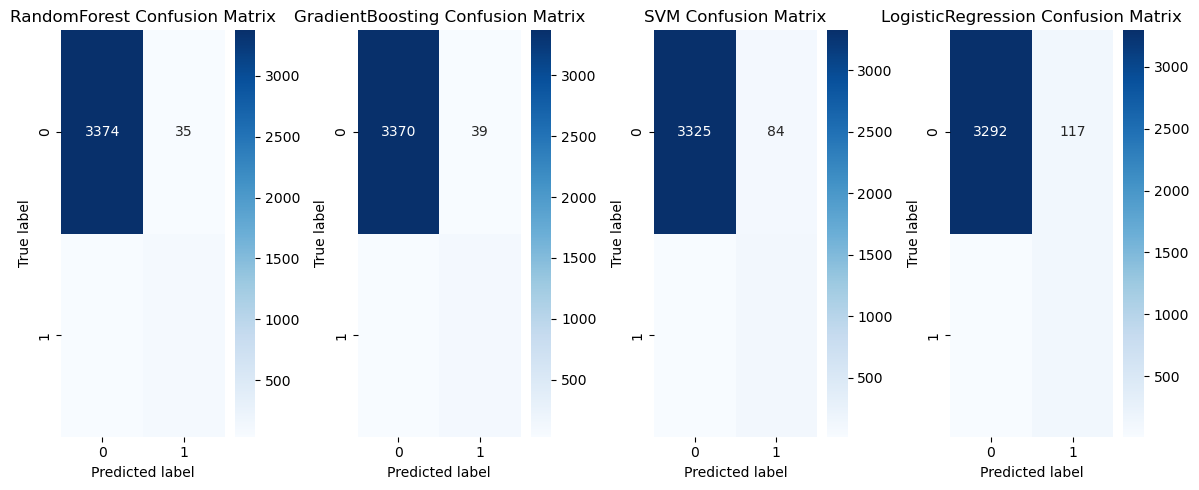


Top 10 Most Important Features for MVP Prediction:
vorp                         0.255670
scoring_efficiency           0.176057
per                          0.144324
pts_per_g                    0.121049
overall_impact               0.102941
bpm                          0.082354
ws_per_48                    0.032209
team_success_contribution    0.028546
defensive_impact             0.020767
win_loss_pct                 0.019184
dtype: float64


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Load historical data for training
data = pd.read_csv('NBA MVP Prediction/NBA_Dataset.csv')

# Remove irrelevant columns
irrelevant_cols = ['player', 'team_id', 'season']
data = data.drop(columns=irrelevant_cols)

# Handle categorical variables
data = pd.get_dummies(data, columns=['pos'])

# Handle missing values
data = data.dropna(axis=1, thresh=len(data) * 0.5)
data = data.fillna(data.median())

# Create composite features
data['scoring_efficiency'] = data['pts_per_g'] * data['fg_pct']
data['overall_impact'] = data['per'] * data['win_loss_pct']
data['defensive_impact'] = data['blk_per_g'] + data['stl_per_g']
data['offensive_efficiency'] = (data['fg_pct'] + data['fg3_pct'] + data['ft_pct'])/3
data['team_success_contribution'] = data['win_loss_pct'] * data['ws_per_48']

# Select key MVP voting features
selected_features = [
    'pts_per_g', 'win_loss_pct', 'per', 'ws_per_48', 'bpm', 
    'vorp', 'scoring_efficiency', 'overall_impact', 
    'defensive_impact', 'offensive_efficiency', 'team_success_contribution'
]

# Add additional selection criteria for MVP candidates
data['mvp_candidate'] = (
    (data['win_loss_pct'] > data['win_loss_pct'].quantile(0.7)) & 
    (data['pts_per_g'] > data['pts_per_g'].quantile(0.7)) & 
    (data['per'] > data['per'].quantile(0.7))
)

# Prepare features and target
X = data[selected_features]
y = (data['award_share'] > 0).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Apply SMOTE with conservative sampling
smote = SMOTE(random_state=42, sampling_strategy=0.10)  # Reduced synthetic sampling
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Original dataset shape:", Counter(y_train))
print("Resampled dataset shape:", Counter(y_train_balanced))

# Initialize models with stricter parameters
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=500,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        class_weight={0:1, 1:5},
        n_jobs=-1,
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.03,
        subsample=0.85,
        min_samples_split=10,
        min_samples_leaf=4,
        validation_fraction=0.2,
        n_iter_no_change=25,
        random_state=42
    ),
    'SVM': SVC(
        probability=True,
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        solver='lbfgs',
        max_iter=2000,
        class_weight='balanced',  # Handle class imbalance
        random_state=42
    )
}

# Function to find optimal threshold
def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.3, 0.7, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        report = classification_report(y_true, y_pred, output_dict=True)
        f1 = report['1']['f1-score']
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

# Train and evaluate models
results = {}
feature_importance = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Find optimal threshold
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
    print(f"Optimal threshold: {optimal_threshold:.3f}")
    
    # Make predictions with optimal threshold
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    
    # Store results
    results[name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    if hasattr(model, 'feature_importances_'):
        feature_importance[name] = pd.Series(
            model.feature_importances_,
            index=X_train.columns
        ).sort_values(ascending=False)

# Print results
for name, result in results.items():
    print(f"\n{name} Results:")
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])
    print("\nClassification Report:")
    print(result['classification_report'])
    print(f"ROC AUC Score: {result['roc_auc']:.4f}")

# Plot confusion matrices
plt.figure(figsize=(12, 5))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 4, i)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Print feature importance
print("\nTop 10 Most Important Features for MVP Prediction:")
print(feature_importance['RandomForest'].head(10))

In [24]:
from sklearn.impute import SimpleImputer

# Load current season data (assumed to be in an Excel file)
current_season_data = pd.read_excel('Current_Season_Stats.xlsx')

# Create composite features for current season data
current_season_data['scoring_efficiency'] = current_season_data['pts_per_g'] * current_season_data['fg_pct']
current_season_data['overall_impact'] = current_season_data['per'] * current_season_data['win_loss_pct']
current_season_data['defensive_impact'] = current_season_data['blk_per_g'] + current_season_data['stl_per_g']
current_season_data['offensive_efficiency'] = (current_season_data['fg_pct'] + current_season_data['fg3_pct'] + current_season_data['ft_pct']) / 3
current_season_data['team_success_contribution'] = current_season_data['win_loss_pct'] * current_season_data['ws_per_48']

# Select the same features for the current season
X_current_season = current_season_data[selected_features]

# Impute missing values using the median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the current season data and transform it
X_current_season_imputed = imputer.fit_transform(X_current_season)

# Scale features after imputation
current_season_scaled = scaler.transform(X_current_season_imputed)

# Predict MVP probabilities for the current season using Random Forest model
current_season_proba = models['GradientBoosting'].predict_proba(current_season_scaled)[:, 1]

# Add MVP probabilities to the current season data for sorting
current_season_data['MVP_Probability'] = current_season_proba

# Sort players by MVP probability and select the top 5
top_candidates = current_season_data.sort_values(by='MVP_Probability', ascending=False).head(15)

# Display top 5 MVP candidates
print("\nTop 15 MVP Candidates:")
print(top_candidates[['player', 'MVP_Probability']])


Top 15 MVP Candidates:
                      player  MVP_Probability
272            Anthony Davis         0.822577
384              Luka Dončić         0.820984
452             Jayson Tatum         0.743585
434  Shai Gilgeous-Alexander         0.699204
222    Giannis Antetokounmpo         0.692223
367           Paolo Banchero         0.557037
417        Jaren Jackson Jr.         0.451454
368             Franz Wagner         0.448096
337            Jalen Brunson         0.423661
288             Nikola Jokić         0.370601
435           Jalen Williams         0.316782
339            Stephen Curry         0.269145
468         Donovan Mitchell         0.267956
225           Damian Lillard         0.250837
338       Karl-Anthony Towns         0.189303


C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [26]:
# Lista de jugadores rookies
rookie_players = [
    "Trey Alexander", "Jamison Battle", "Reece Beekman", "Adem Bona", "Jalen Bridges", 
    "Matas Buzelis", "Branden Carlson", "Carlton Carrington", "Stephon Castle", "Ulrich Chomche", 
    "Cam Christie", "Donovan Clingan", "Isaiah Collier", "Isaiah Crawford", "Cui Yongxi", 
    "Tristan Da Silva", "Pacome Dadiet", "Rob Dillingham", "Alex Ducas", "Ryan Dunn", 
    "Zach Edey", "Justin Edwards", "Kyle Filipowski", "Trentyn Flowers", "Enrique Freeman", 
    "Johnny Furphy", "Kyshawn George", "Jazian Gortman", "PJ Hall", "Ron Holland", 
    "Ariel Hukporti", "Oso Ighodaro", "Harrison Ingram", "Bronny James", "Daniss Jenkins", 
    "AJ Johnson", "Keshad Johnson", "Dillon Jones", "Isaac Jones", "Spencer Jones", 
    "Yuki Kawamura", "Dalton Knecht", "Tyler Kolek", "Pelle Larsson", "Malevy Leons", 
    "Jaylen Martin", "Karlo Matković", "Jared McCain", "Jack McVeigh", "Riley Minix", 
    "Yves Missi", "Ajay Mitchell", "Jonathan Mogbo", "Tristen Newton", "Quincy Olivari", 
    "Alex Reese", "Antonio Reeves", "Zaccharie Risacher", "Liam Robbins", "Tidjane Salaün", 
    "Alex Sarr", "Baylor Scheierman", "Terrence Shannon Jr.", "Jamal Shead", "Reed Sheppard", 
    "KJ Simpson", "Tyler Smith", "Cam Spencer", "Armel Traoré", "Luke Travers", 
    "Jaylon Tyson", "Keaton Wallace", "Ja'Kobe Walter", "Kel'el Ware", "Jaylen Wells", 
    "Cody Williams"
]

# Filtrar el dataset para incluir solo jugadores rookies
rookies_data = current_season_data[current_season_data['player'].isin(rookie_players)]

# Filtrar el dataset para incluir solo jugadores rookies que hayan jugado más de 5 partidos y más de 6 minutos por partido
filtered_rookies_data = current_season_data[
    current_season_data['player'].isin(rookie_players) &
    (current_season_data['g'] > 6) &  # Más de 5 partidos jugados
    (current_season_data['mp_per_g'] > 8)  # Más de 6 minutos por partido
]

# Crear características para los rookies filtrados
X_filtered_rookies = filtered_rookies_data[selected_features]

# Imputar valores faltantes usando la estrategia de la mediana
imputer = SimpleImputer(strategy='median')

# Ajustar el imputador con los datos de los rookies filtrados y transformarlos
X_filtered_rookies_imputed = imputer.fit_transform(X_filtered_rookies)

# Escalar características después de la imputación
filtered_rookies_scaled = scaler.transform(X_filtered_rookies_imputed)

# Predecir probabilidades de MVP para los rookies filtrados usando el modelo Gradient Boosting
filtered_rookie_proba = models['GradientBoosting'].predict_proba(filtered_rookies_scaled)[:, 1]

# Agregar probabilidades de MVP a los datos de los rookies filtrados
filtered_rookies_data['MVP_Probability'] = filtered_rookie_proba

# Ordenar los jugadores por probabilidad de MVP y seleccionar los top 5
top_5_filtered_rookie_candidates = filtered_rookies_data.sort_values(by='MVP_Probability', ascending=False).head(15)

# Mostrar los top 5 candidatos al MVP (rookies filtrados)
print("\nTop 15 ROY Candidates:")
print(top_5_filtered_rookie_candidates[['player', 'MVP_Probability']])



Top 15 ROY Candidates:
                 player  MVP_Probability
91         Jared McCain         0.000738
6             Alex Sarr         0.000540
422           Zach Edey         0.000453
114     Donovan Clingan         0.000451
194      Stephon Castle         0.000361
25           Yves Missi         0.000359
211  Zaccharie Risacher         0.000355
305       Pelle Larsson         0.000343
7    Carlton Carrington         0.000341
9        Kyshawn George         0.000340
375    Tristan Da Silva         0.000338
359      Ariel Hukporti         0.000336
251      Rob Dillingham         0.000329
250        Oso Ighodaro         0.000329
180         Isaac Jones         0.000329


C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Marc\AppData\Local\Temp\ipykernel_20728\194813571.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rookies_data['MVP_Probability'] = filtered_rookie_proba


In [28]:
# Load current season data (assumed to be in an Excel file)
current_season_data = pd.read_excel('Current_Season_Stats.xlsx')

# Create composite features for current season data
current_season_data['scoring_efficiency'] = current_season_data['pts_per_g'] * current_season_data['fg_pct']
current_season_data['overall_impact'] = current_season_data['per'] * current_season_data['win_loss_pct']
current_season_data['defensive_impact'] = current_season_data['blk_per_g'] + current_season_data['stl_per_g']
current_season_data['offensive_efficiency'] = (current_season_data['fg_pct'] + current_season_data['fg3_pct'] + current_season_data['ft_pct']) / 3
current_season_data['team_success_contribution'] = current_season_data['win_loss_pct'] * current_season_data['ws_per_48']

SMOY_data = current_season_data[
    (current_season_data['gs'] < 5) &  # Más de 5 partidos jugados
    (current_season_data['g'] > 15)
]

# Select the same features for the current season
X_current_season = SMOY_data[selected_features]

# Impute missing values using the median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the current season data and transform it
X_current_season_imputed = imputer.fit_transform(X_current_season)

# Scale features after imputation
current_season_scaled = scaler.transform(X_current_season_imputed)

# Predict MVP probabilities for the current season using Random Forest model
current_season_proba = models['GradientBoosting'].predict_proba(current_season_scaled)[:, 1]

# Add MVP probabilities to the current season data for sorting
SMOY_data['MVP_Probability'] = current_season_proba

# Sort players by MVP probability and select the top 5
top_candidates = SMOY_data.sort_values(by='MVP_Probability', ascending=False).head(15)

# Display top 5 MVP candidates
print("\nTop 15 MVP Candidates:")
print(top_candidates[['player', 'MVP_Probability']])


Top 15 MVP Candidates:
               player  MVP_Probability
396        Tari Eason         0.013651
456  Payton Pritchard         0.005588
370     Moritz Wagner         0.001240
376    Jonathan Isaac         0.001200
472      Caris LeVert         0.001022
393     Amen Thompson         0.001020
480  Craig Porter Jr.         0.000832
473         Ty Jerome         0.000816
474     Georges Niang         0.000759
353      Kevon Looney         0.000714
344       Buddy Hield         0.000698
178        Keon Ellis         0.000590
212    Onyeka Okongwu         0.000547
349     Cameron Payne         0.000506
346     Miles McBride         0.000493


C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Marc\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Marc\AppData\Local\Temp\ipykernel_20728\2184292855.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SMOY_data['MVP_Probability'] = current_season_proba


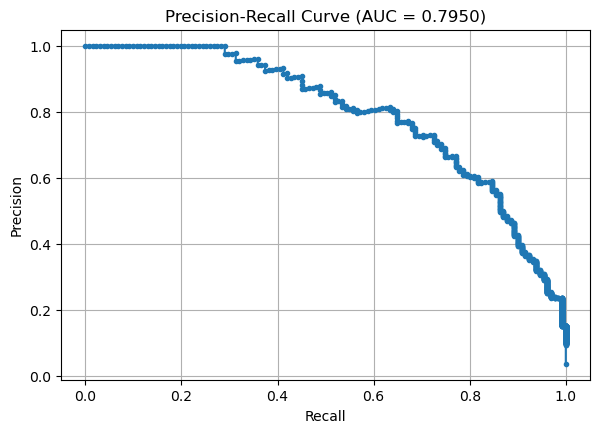

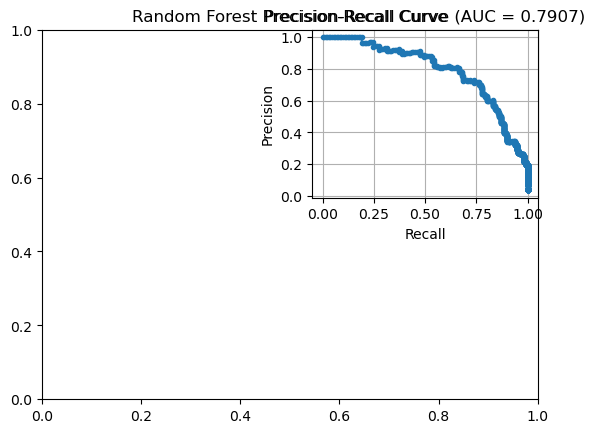

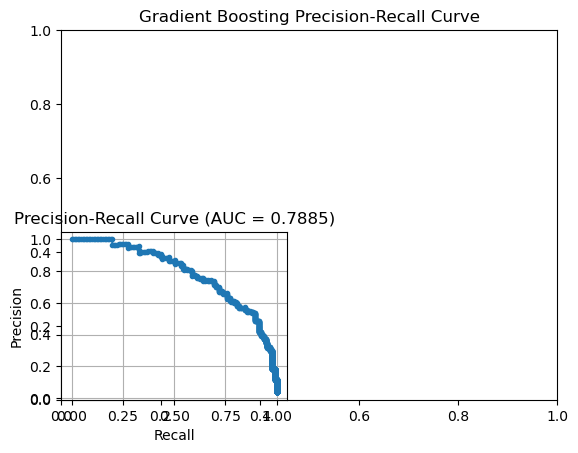

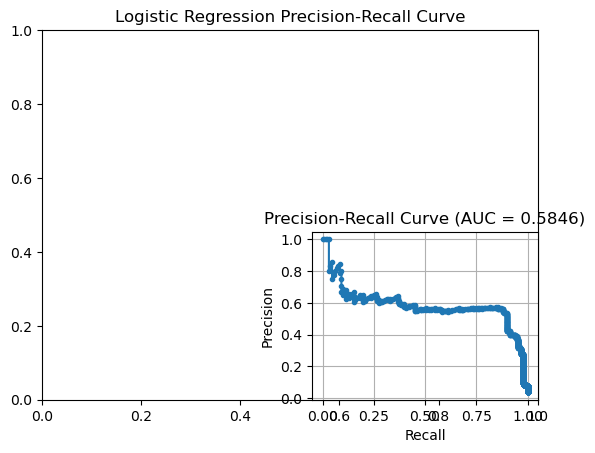

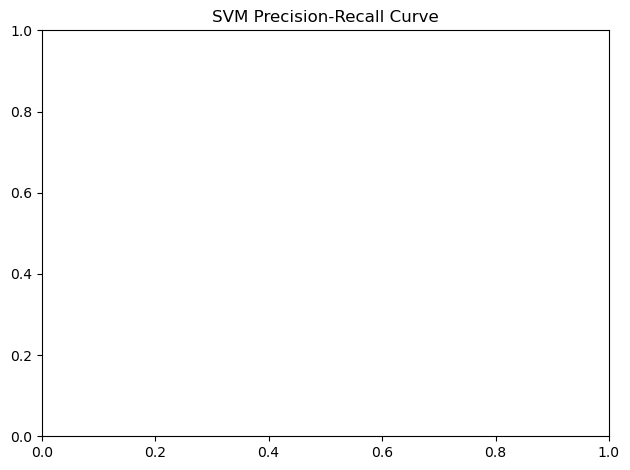

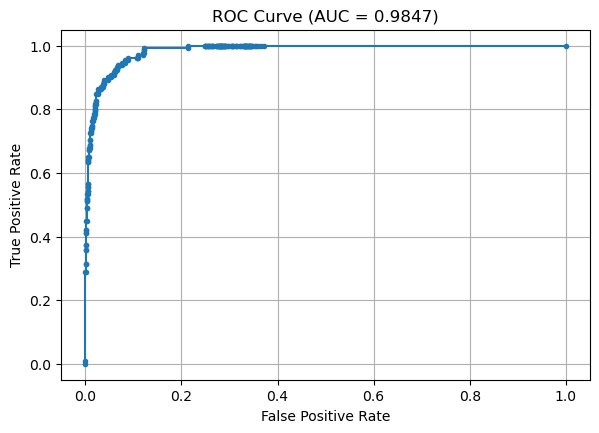

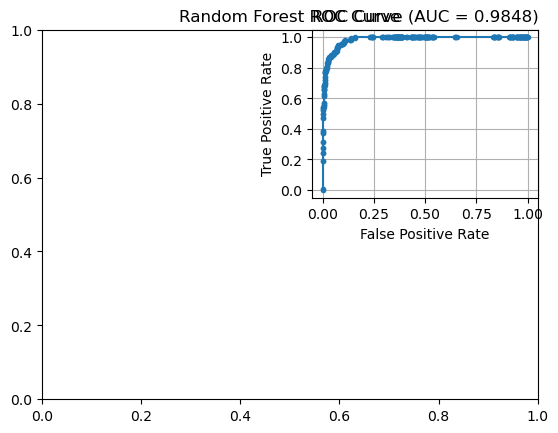

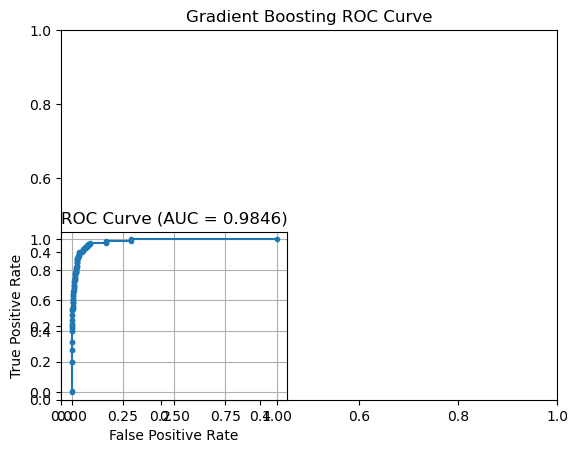

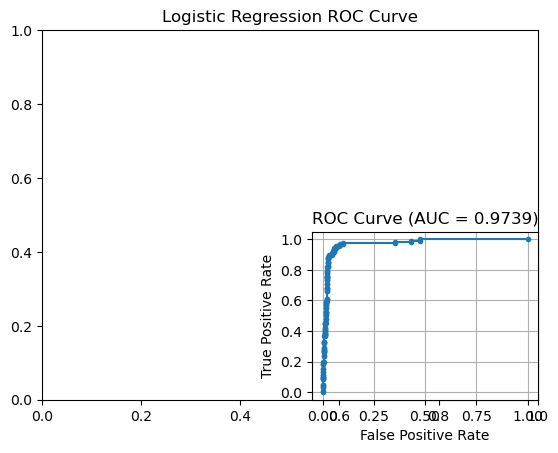

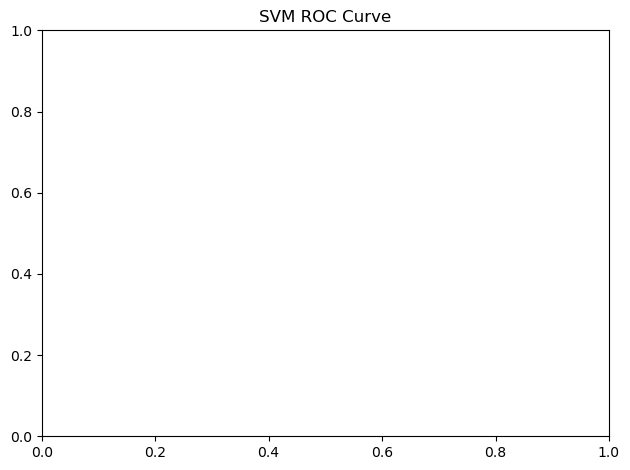

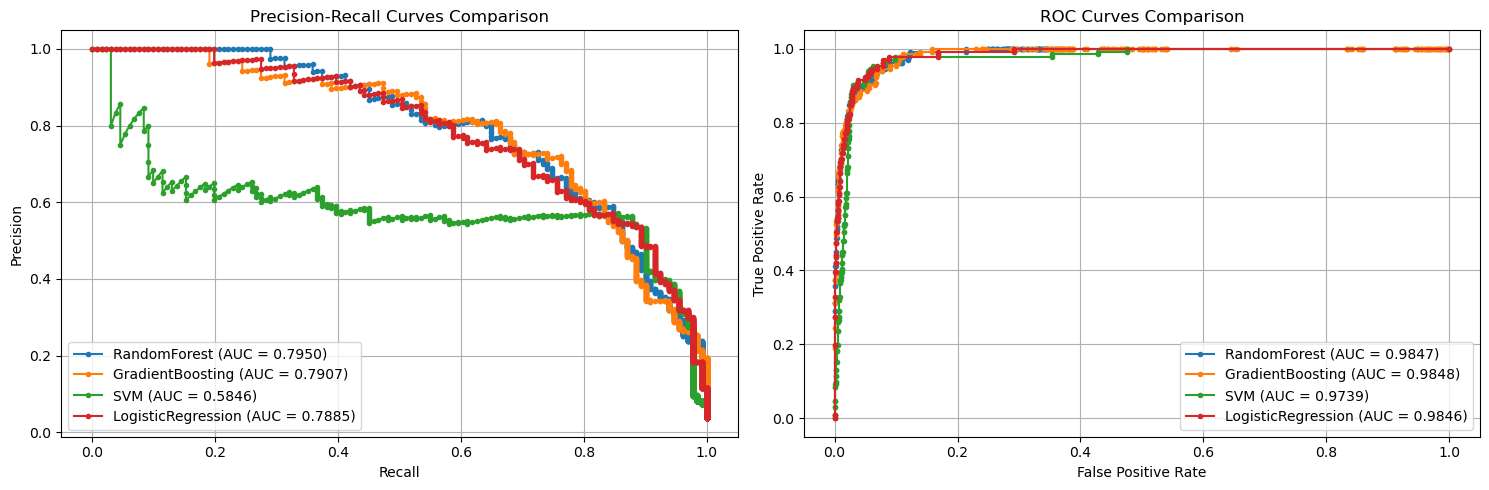

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
import numpy as np

def plot_precision_recall(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, marker='.')
    plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    plt.plot(fpr, tpr, marker='.')
    plt.title(f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

# Create subplots for all models
plt.figure(figsize=(15, 10))

# Precision-Recall curves
plt.subplot(2, 2, 1)
plot_precision_recall(y_test, results['RandomForest']['probabilities'])
plt.title('Random Forest Precision-Recall Curve')

plt.subplot(2, 2, 2)
plot_precision_recall(y_test, results['GradientBoosting']['probabilities'])
plt.title('Gradient Boosting Precision-Recall Curve')

plt.subplot(2, 2, 3)
plot_precision_recall(y_test, results['LogisticRegression']['probabilities'])
plt.title('Logistic Regression Precision-Recall Curve')

plt.subplot(2, 2, 4)
plot_precision_recall(y_test, results['SVM']['probabilities'])
plt.title('SVM Precision-Recall Curve')

plt.tight_layout()
plt.show()

# ROC curves
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plot_roc_curve(y_test, results['RandomForest']['probabilities'])
plt.title('Random Forest ROC Curve')

plt.subplot(2, 2, 2)
plot_roc_curve(y_test, results['GradientBoosting']['probabilities'])
plt.title('Gradient Boosting ROC Curve')

plt.subplot(2, 2, 3)
plot_roc_curve(y_test, results['LogisticRegression']['probabilities'])
plt.title('Logistic Regression ROC Curve')

plt.subplot(2, 2, 4)
plot_roc_curve(y_test, results['SVM']['probabilities'])
plt.title('SVM ROC Curve')

plt.tight_layout()
plt.show()

# Plot all curves on single plots for comparison
plt.figure(figsize=(15, 5))

# Precision-Recall curves in one plot
plt.subplot(1, 2, 1)
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['probabilities'])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, marker='.', label=f'{name} (AUC = {pr_auc:.4f})')

plt.title('Precision-Recall Curves Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(True)

# ROC curves in one plot
plt.subplot(1, 2, 2)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    roc_auc = roc_auc_score(y_test, result['probabilities'])
    plt.plot(fpr, tpr, marker='.', label=f'{name} (AUC = {roc_auc:.4f})')

plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

Loading data...
Adding DPOY winners...
Filtering candidates...
Creating features...
Splitting and scaling data...
Training rf model...
Training gb model...
Training lr model...
Training svm model...

Results:

RandomForest Results:
Best threshold: 0.50

Confusion Matrix:
[[1106  171]
 [   3   11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1277
           1       0.06      0.79      0.11        14

    accuracy                           0.87      1291
   macro avg       0.53      0.83      0.52      1291
weighted avg       0.99      0.87      0.92      1291

ROC AUC Score: 0.9460

GradientBoosting Results:
Best threshold: 0.50

Confusion Matrix:
[[1213   64]
 [   4   10]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1277
           1       0.14      0.71      0.23        14

    accuracy                           0.95   

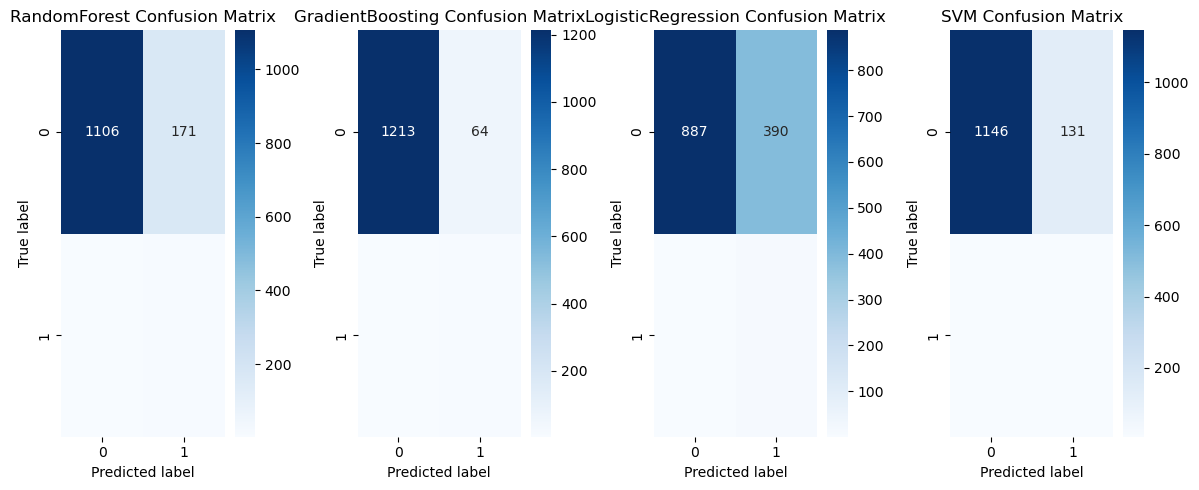

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score

def load_data(file_path):
    print("Loading data...")
    data = pd.read_csv(file_path)
    return data

def add_dpoy_winners(data):
    dpoy_list = {
        2022: "Marcus Smart", 2021: "Rudy Gobert", 2020: "Giannis Antetokounmpo",
        2019: "Rudy Gobert", 2018: "Rudy Gobert", 2017: "Draymond Green",
        2016: "Kawhi Leonard", 2015: "Kawhi Leonard", 2014: "Joakim Noah",
        2013: "Marc Gasol", 2012: "Tyson Chandler", 2011: "Dwight Howard",
        2010: "Dwight Howard", 2009: "Dwight Howard", 2008: "Kevin Garnett",
        2007: "Marcus Camby", 2006: "Ben Wallace", 2005: "Ben Wallace",
        2004: "Metta World Peace", 2003: "Ben Wallace", 2002: "Ben Wallace",
        2001: "Dikembe Mutombo", 2000: "Alonzo Mourning", 1999: "Alonzo Mourning",
        1998: "Dikembe Mutombo", 1997: "Dikembe Mutombo", 1996: "Gary Payton",
        1995: "Dikembe Mutombo", 1994: "Hakeem Olajuwon", 1993: "Hakeem Olajuwon",
        1992: "David Robinson", 1991: "Dennis Rodman", 1990: "Dennis Rodman",
        1989: "Mark Eaton", 1988: "Michael Jordan", 1987: "Michael Cooper",
        1986: "Alvin Robertson", 1985: "Mark Eaton", 1984: "Sidney Moncrief",
        1983: "Sidney Moncrief"
    }
    
    print("Adding DPOY winners...")
    data['dpoy_winner'] = data.apply(
        lambda row: 1 if (row['season'] in dpoy_list and row['player'] == dpoy_list[row['season']]) else 0,
        axis=1
    )
    return data

def create_features(df):
    print("Creating features...")
    features = pd.DataFrame()
    
    # Core defensive rankings
    features['blocks_rank'] = df['blk_per_g'].rank(pct=True)
    features['steals_rank'] = df['stl_per_g'].rank(pct=True)
    features['dws_rank'] = df['dws'].rank(pct=True)
    features['dbpm_rank'] = df['dbpm'].rank(pct=True)
    
    # Create excellence scores (0 or 1 for each category)
    features['block_excellence'] = (features['blocks_rank'] > 0.95).astype(int)
    features['steal_excellence'] = (features['steals_rank'] > 0.95).astype(int)
    features['dws_excellence'] = (features['dws_rank'] > 0.95).astype(int)
    features['dbpm_excellence'] = (features['dbpm_rank'] > 0.95).astype(int)
    
    # Overall defensive excellence score
    features['defensive_excellence'] = (
        features['block_excellence'] + 
        features['steal_excellence'] + 
        features['dws_excellence'] + 
        features['dbpm_excellence']
    )
    
    # Team success and playing time
    features['win_pct_rank'] = df['win_loss_pct'].rank(pct=True)
    features['minutes_rank'] = (df['mp_per_g'] * df['g'] / 82).rank(pct=True)
    
    # Team success excellence
    features['team_excellence'] = (features['win_pct_rank'] > 0.8).astype(int)
    features['minutes_excellence'] = (features['minutes_rank'] > 0.8).astype(int)
    
    # Elite defender criteria (very strict)
    features['elite_defender'] = (
        (features['defensive_excellence'] >= 2) &  # At least 2 defensive categories in top 5%
        features['team_excellence'] &              # Team in top 20%
        features['minutes_excellence']             # Minutes in top 20%
    ).astype(int)
    
    # Super elite defender (even stricter)
    features['super_elite'] = (
        (features['defensive_excellence'] >= 3) &  # At least 3 defensive categories in top 5%
        (features['win_pct_rank'] > 0.9) &        # Team in top 10%
        (features['minutes_rank'] > 0.9)          # Minutes in top 10%
    ).astype(int)
    
    return features

def filter_candidates(data, min_percentile=0.7):
    print("Filtering candidates...")
    defensive_score = (
        data['blk_per_g'].rank(pct=True) +
        data['stl_per_g'].rank(pct=True) +
        data['dws'].rank(pct=True) +
        data['dbpm'].rank(pct=True)
    ) / 4
    
    return data[
        (defensive_score > min_percentile) |
        (data['dpoy_winner'] == 1)
    ]

def train_ensemble_model(X_train, y_train, X_test, y_test, model_type='rf'):
    print(f"Training {model_type} model...")
    ensemble_preds = []
    n_models = 10
    
    # Get minority and majority indices
    dpoy_idx = np.where(y_train == 1)[0]
    non_dpoy_idx = np.where(y_train == 0)[0]
    
    for i in range(n_models):
        # Sample sizes
        n_dpoy = min(40, len(non_dpoy_idx) // 4)
        n_non_dpoy = n_dpoy * 2
        
        # Sample indices
        sampled_dpoy = np.random.choice(dpoy_idx, size=n_dpoy, replace=True)
        sampled_non_dpoy = np.random.choice(non_dpoy_idx, size=n_non_dpoy, replace=False)
        
        # Combine samples
        indices = np.concatenate([sampled_dpoy, sampled_non_dpoy])
        np.random.shuffle(indices)
        
        # Create balanced dataset
        X_balanced = X_train.iloc[indices]
        y_balanced = y_train.iloc[indices]
        
        # Train model
        if model_type == 'rf':
            model = RandomForestClassifier(
                n_estimators=500,
                max_depth=6,
                min_samples_split=5,
                min_samples_leaf=3,
                class_weight={0:1, 1:8},
                n_jobs=-1,
                random_state=i
            )
        elif model_type == 'gb':
            model = GradientBoostingClassifier(
                n_estimators=500,
                max_depth=4,
                learning_rate=0.01,
                subsample=0.8,
                min_samples_split=5,
                min_samples_leaf=3,
                random_state=i
            )
        elif model_type == 'lr':
            model = LogisticRegression(
                penalty='l2',
                C=1.0,
                class_weight={0:1, 1:8},
                random_state=i
            )
        elif model_type == 'svm':
            model = SVC(
                C=1.0,
                kernel='rbf',
                class_weight={0:1, 1:8},
                probability=True,
                random_state=i
            )
        
        model.fit(X_balanced, y_balanced)
        pred_proba = model.predict_proba(X_test)[:, 1]
        ensemble_preds.append(pred_proba)
    
    # Average predictions
    avg_preds = np.mean(ensemble_preds, axis=0)
    
    # Find optimal threshold
    best_threshold = 0.5
    best_f1 = 0
    best_predictions = None
    
    for threshold in np.arange(0.3, 0.8, 0.01):
        y_pred = (avg_preds >= threshold).astype(int)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        
        # Require minimum precision and recall
        if prec >= 0.4 and rec >= 0.4:
            f1 = 2 * (prec * rec) / (prec + rec)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                best_predictions = y_pred.copy()
    
    # If no good threshold found, use default
    if best_predictions is None:
        best_threshold = 0.5
        best_predictions = (avg_preds >= best_threshold).astype(int)
    
    return {
        'predictions': best_predictions,
        'probabilities': avg_preds,
        'threshold': best_threshold
    }


# Load and prepare data
data = load_data('NBA MVP Prediction/NBA_Dataset.csv')
data = add_dpoy_winners(data)
data_filtered = filter_candidates(data)
    
# Create features
X = create_features(data_filtered)
y = data_filtered['dpoy_winner']
    
# Split data
print("Splitting and scaling data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)
    
    # Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)
    
    # Train models
models = {
    'RandomForest': 'rf',
    'GradientBoosting': 'gb',
    'LogisticRegression': 'lr',
    'SVM': 'svm'
}

results = {}
for name, model_type in models.items():
    results[name] = train_ensemble_model(
        X_train_scaled, y_train, 
        X_test_scaled, y_test, 
        model_type
    )
    
    # Print results
print("\nResults:")
for name, result in results.items():
    print(f"\n{name} Results:")
    print(f"Best threshold: {result['threshold']:.2f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, result['predictions']))
    print("\nClassification Report:")
    print(classification_report(y_test, result['predictions']))
    print(f"ROC AUC Score: {roc_auc_score(y_test, result['probabilities']):.4f}")
    
    # Plot confusion matrices
plt.figure(figsize=(12, 5))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 4, i)
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [33]:
# Load current season stats from Excel
current_season_path = 'Current_Season_Stats.xlsx'
print("\nLoading current season stats from Excel...")
current_data = pd.read_excel(current_season_path)

# Add features for the current season data
print("Adding features to current season data...")
current_features = create_features(current_data)

# Scale current season features
print("Scaling current season features...")
current_features_scaled = pd.DataFrame(
    scaler.transform(current_features),
    columns=current_features.columns
)

# Predict probabilities for the current season using the trained ensemble
print("\nGenerating predictions for current season stats...")
ensemble_preds_current = []
n_models = 10

for i in range(n_models):
    # Train a Random Forest model on the training data for this ensemble iteration
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=3,
        class_weight={0: 1, 1: 8},
        n_jobs=-1,
        random_state=i
    )
    model.fit(X_train_scaled, y_train)  # Train on the original training data
    pred_proba_current = model.predict_proba(current_features_scaled)[:, 1]  # Predict probabilities
    ensemble_preds_current.append(pred_proba_current)

# Average predictions for the current season
current_probabilities = np.mean(ensemble_preds_current, axis=0)

# Check lengths before assigning probabilities
print(f"Length of current_data: {len(current_data)}")
print(f"Length of current_probabilities: {len(current_probabilities)}")

# Assign probabilities to the DataFrame
current_data['dpoy_probability'] = current_probabilities

# Sort players by DPOY probability and select the top 5
top_candidates = current_data[['player', 'team_id', 'dpoy_probability']].sort_values(
    by='dpoy_probability', ascending=False
).head(15)

# Display top 5 candidates
print("\nTop 15 DPOY Candidates:")
print(top_candidates)



Loading current season stats from Excel...
Adding features to current season data...
Creating features...
Scaling current season features...

Generating predictions for current season stats...
Length of current_data: 500
Length of current_probabilities: 500

Top 15 DPOY Candidates:
                       player team_id  dpoy_probability
396                Tari Eason     HOU          0.600767
435            Jalen Williams     OKC          0.517309
441             Cason Wallace     OKC          0.503571
434   Shai Gilgeous-Alexander     OKC          0.373840
330                 Kris Dunn     LAC          0.351408
442               Alex Caruso     OKC          0.345948
189         Victor Wembanyama     SAS          0.295348
368              Franz Wagner     ORL          0.294655
417         Jaren Jackson Jr.     MEM          0.276449
288              Nikola Jokić     DEN          0.269909
470               Evan Mobley     CLE          0.269415
372  Kentavious Caldwell-Pope     ORL       